## Clustering method

This tutorial gives a bit more detail about clustering methods and how to implement your own.


In [1]:
# Prerequisites
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

In [ ]:
from toad import TOAD

td = TOAD(
    xr.open_dataset("test_data/garbe_2020_antarctica.nc")
    .coarsen(x=3, y=3, time=3, boundary="trim")
    .reduce(np.mean)
)

td.data = td.data.drop_vars(
    ["lat", "lon"]
)  # drop lat/lon to use the native coordinates

In [3]:
# shifts have been precomputed
# td.compute_shifts('thk')

The `td.compute_clusters` function accepts clustering methods from the `sklearn.cluster` module.


In [4]:
from sklearn.cluster import DBSCAN, HDBSCAN

# HDBSCAN
td.compute_clusters(
    "thk",
    method=HDBSCAN(
        min_cluster_size=25,
        min_samples=5,  # optional, defaults to min_cluster_size
        cluster_selection_epsilon=0.1,  # optional, defauls to 0
        metric="euclidean",  # optional, defaults to 'euclidean'
    ),
    shift_threshold=0.8,
    overwrite=True,
)

# DBSCAN
td.compute_clusters(
    "thk",
    method=DBSCAN(
        eps=0.1,
        min_samples=5,
        metric="euclidean",  # optional, defaults to 'euclidean'
    ),
    shift_threshold=0.8,
    overwrite=True,
)

## Defining your own clustering method

You can also define your own clustering method by extending the `sklearn.base.ClusterMixin` and `sklearn.base.BaseEstimator` classes:


In [5]:
from sklearn.base import ClusterMixin, BaseEstimator


# Your custom clustering class must inherit from ClusterMixin and BaseEstimator
class MyClusterer(ClusterMixin, BaseEstimator):
    # Pass params to your method here
    def __init__(self, my_param):
        self.my_param = my_param

    # required method to perform clustering
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        cluster_labels_array = ...  # your clustering algorithm here
        return cluster_labels_array


# Then apply it with TOAD
# td.compute_clusters('thk',
#     method=MyClusterer(
#         my_param=(1, 2.0, 2.0), # time, x, y thresholds
#     ),
#     shift_threshold=0.8,
#     overwrite=True,
# )

Real example of a custom clustering method:


In [6]:
from sklearn.base import BaseEstimator, ClusterMixin


class ExampleClusterer(ClusterMixin, BaseEstimator):
    # required method
    def __init__(self, my_param=(0.5, 1.0, 1.0)):
        self.my_param = my_param

    # required method
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        # Perform extremely crude clustering
        clusters = []
        cluster_labels_array = []
        for point in coords:
            for i, centroid in enumerate(clusters):
                if all(abs(point - centroid) <= self.my_param):
                    break
            else:
                clusters.append(point)
                i = len(clusters) - 1
            cluster_labels_array.append(i)

        return cluster_labels_array


td = TOAD(
    xr.open_dataset("test_data/garbe_2020_antarctica.nc")
    .coarsen(x=1, y=1, time=3, boundary="trim")
    .reduce(np.mean)
)
td.compute_clusters(
    "thk",
    method=ExampleClusterer(
        my_param=(0.5, 2.0, 2.0),  # time, x, y thresholds
    ),
    shift_threshold=0.8,
    overwrite=True,
)

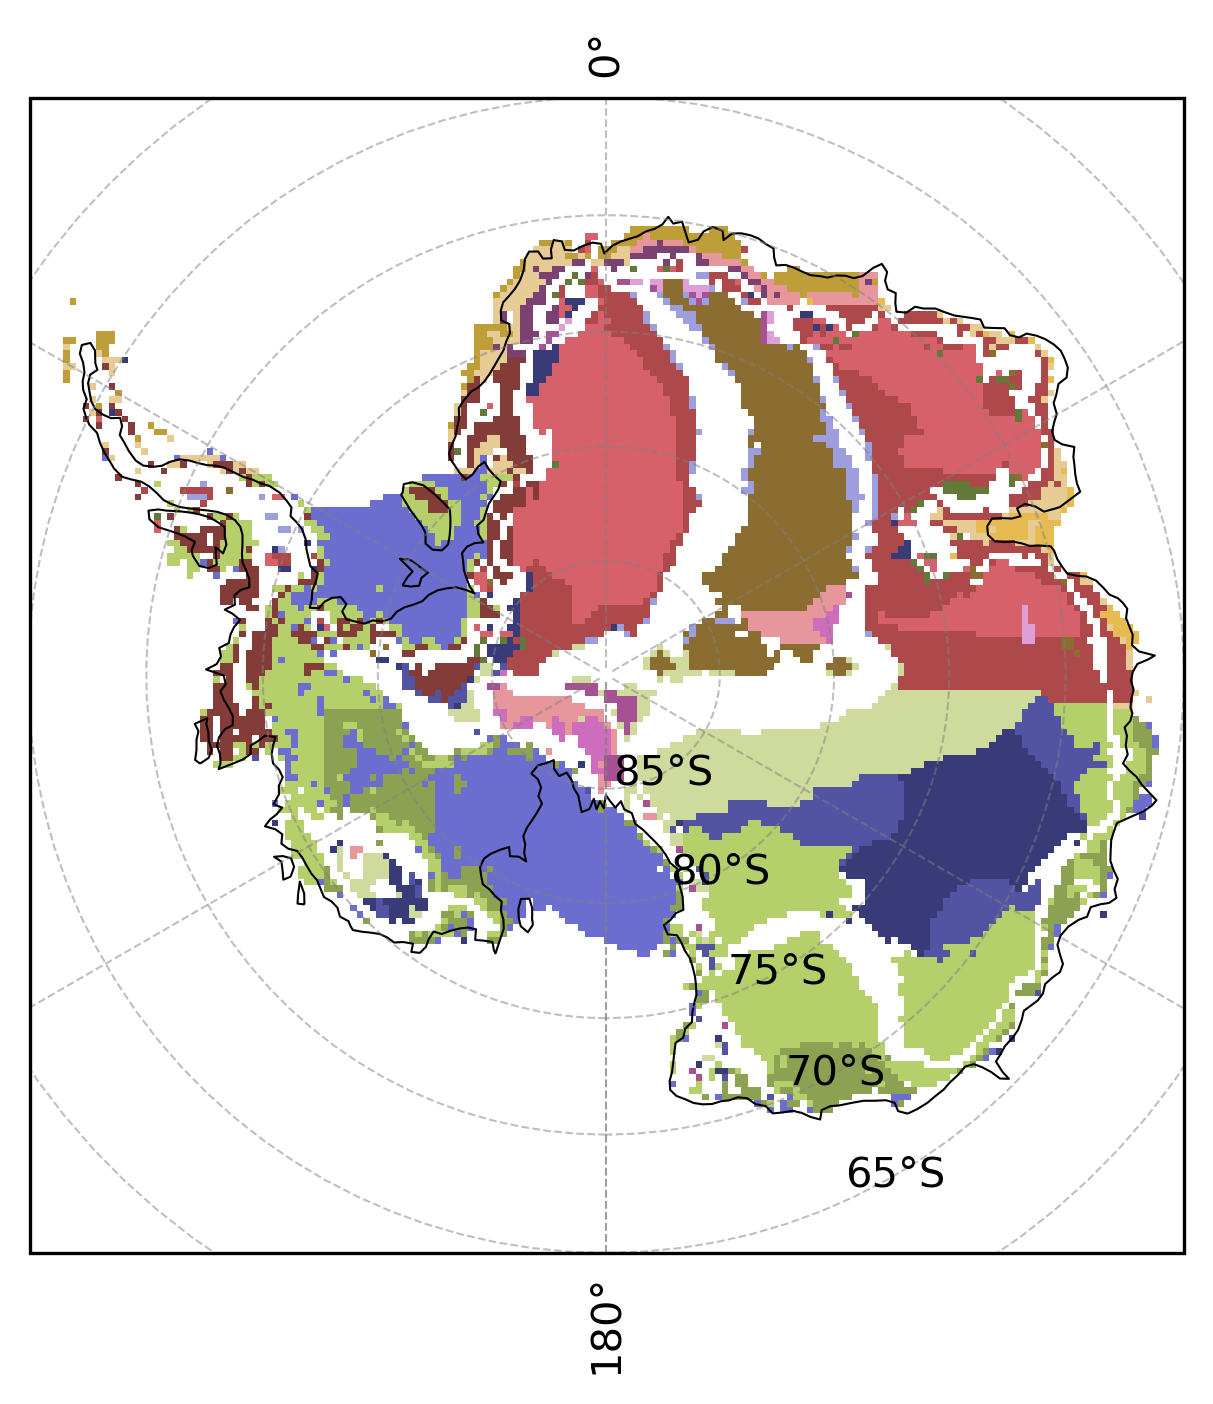

In [20]:
td.plotter().cluster_map(
    "thk", projection="south_pole", add_labels=False, add_contour=False
);